# 3x3の迷路ゲームの強化学習

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 進める方向は1, 壁があるならnp.nanとする
行がs0 ~ s7. s8はゴールなので方策を定義しない.
列は移動する四方向.

In [2]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],
                    [np.nan, 1, np.nan, 1],
                    [np.nan, np.nan, 1, 1],
                    [1, 1, 1, np.nan],
                    [np.nan, np.nan, 1, 1],
                    [1, np.nan, np.nan, np.nan],
                    [1, np.nan, np.nan, np.nan],
                    [1, 1, np.nan, np.nan]])

In [3]:
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [nan, nan,  1.,  1.],
       [ 1.,  1.,  1., nan],
       [nan, nan,  1.,  1.],
       [ 1., nan, nan, nan],
       [ 1., nan, nan, nan],
       [ 1.,  1., nan, nan]])

In [4]:
theta_0.shape

(8, 4)

In [5]:
def simple_convert_into_pi_from_theta(theta):
    '''
        単純に割合を計算する
    '''
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :]/np.nansum(theta[i, :])  # nansum : nanは0としてsumをとる.
    pi = np.nan_to_num(pi)  # nan -> 0へ置換.
    return pi


## 初期の方策pi_0を求める

In [6]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

## 1step移動後の状態sを求める

In [7]:
def get_next_s(pi, s):
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == 'up':
        s_next = s - 3
    elif next_direction == 'right':
        s_next = s + 1
    elif next_direction == 'down':
        s_next = s + 3
    else:
        s_next = s - 1
    return s_next

## エージェントが迷路をゴールするまで永遠に移動させる関数の定義

In [8]:
def goal_maze(pi):
    s = 0 # スタート地点
    state_history = [0] # エージェントの移動を記録するリスト.
    
    while(1):
        next_s = get_next_s(pi, s)
        state_history.append(next_s)
        
        if next_s == 8:  # goal
            break
        else:
            s = next_s
    return state_history

In [9]:
state_history = goal_maze(pi_0)
state_history

[0,
 1,
 2,
 5,
 2,
 1,
 0,
 1,
 0,
 3,
 4,
 3,
 4,
 7,
 4,
 3,
 0,
 1,
 2,
 1,
 0,
 3,
 6,
 3,
 4,
 3,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 5,
 2,
 5,
 2,
 1,
 2,
 5,
 2,
 1,
 0,
 1,
 0,
 1,
 2,
 5,
 2,
 5,
 2,
 1,
 0,
 3,
 0,
 3,
 6,
 3,
 0,
 3,
 0,
 1,
 0,
 1,
 2,
 5,
 2,
 1,
 2,
 5,
 2,
 1,
 0,
 1,
 0,
 3,
 4,
 7,
 4,
 7,
 8]

## ゴール到達までのstep数

In [10]:
len(state_history) - 1

80

## 方策勾配法に従ってエージェントを動かす

In [11]:
def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    
    exp_theta = np.exp(beta * theta)
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])  # 各sに対してsoftmaxから得られる確率値を与える.
    
    pi = np.nan_to_num(pi)
    
    return pi

In [12]:
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

## 行動aした際のnext stateを返す

In [13]:
def get_action_and_next_s(pi, s):
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == 'up':
        action = 0
        s_next = s - 3
    elif next_direction == 'right':
        action = 1
        s_next = s + 1
    elif next_direction == 'down':
        action = 2
        s_next = s + 3
    else:
        action = 3
        s_next = s - 1
    return [action, s_next]

## 迷路を解く関数の定義、状態と行動の履歴を出力

In [14]:
# [s0, action0]
# [s1, action1]
# [s2, action2]
#     :
#     :
# [s8, actionN]

def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0, np.nan]]  # [current_state, previous_action]
    
    while(1):
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action  # 最新の履歴にnext_actionを刻む
        
        s_a_history.append([next_s, np.nan])  # 
        
        if next_s == 8:  # goal
            break
        else:
            s = next_s
    return s_a_history

In [15]:
s_a_history = goal_maze_ret_s_a(pi_0)
s_a_history

[[0, 1],
 [1, 3],
 [0, 1],
 [1, 3],
 [0, 2],
 [3, 1],
 [4, 3],
 [3, 0],
 [0, 2],
 [3, 1],
 [4, 2],
 [7, 1],
 [8, nan]]

## 方策勾配法に基づいて方策を更新する
```math
delta_theta = (N_ij - pi[i, j] * N_i) / T
            = (N_ij)/T - (pi[i,j] * N_i)/T
            = (状態iで行動jが選択されたstep数)/(総step数) - (方策π(i,j)から計算される状態sで行動iが選択される回数の期待値)/(総step数)
new_theta = theta + eta*delta_theta
```

In [16]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1
    T = len(s_a_history) - 1  # ゴールまでの総ステップ数
    
    [m, n] = theta.shape
    delta_theta = theta.copy()
    
    for i in range(m):  # i : sに関するidx
        for j in range(n):   # j : actionに関するidx
            if not np.isnan(theta[i, j]):
                # 履歴から状態iのものを取り出す
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 状態iで行動jをしたものを取り出す
                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 一致しなかったら空リスト
                #print('i:', i, ' j:', j)
                #print('SA_i : ', SA_i)
                #print('SA_ij : ', SA_ij)
                #print()
                
                N_i = len(SA_i)  # 状態i(s∍i)で行動した総回数
                N_ij = len(SA_ij)  # 状態i(s∍i)で行動jをとった回数
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T  # NOTE ここを起点に読むとよい
    new_theta = theta + eta * delta_theta
    
    return new_theta

In [17]:
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
pi

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.49583343, 0.        , 0.50416657],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33332562, 0.33611494, 0.33055945, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.49791668, 0.50208332, 0.        , 0.        ]])

## 方策勾配法で迷路を解く

In [18]:
stop_eps = 10**-4
losses = []
theta = theta_0
pi = pi_0
is_continue = True
count = 1
while is_continue:
    # 現在の方策piに従って移動. 履歴を取得.
    s_a_history = goal_maze_ret_s_a(pi)
    # 方策勾配法に従ってthetaの更新.
    new_theta = update_theta(theta, pi, s_a_history)
    # 更新後のthetaから新しい方策piへとsoftmaxで変換する.
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    loss = np.sum(np.abs(new_pi - pi))
    losses.append(loss)
    
    #print(loss)
    #print('total step at the end of episode : ', len(s_a_history) - 1)
    
    if loss < stop_eps:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi
        
print(loss)
print('total step at the end of episode : ', len(s_a_history) - 1)
    

9.995992986744709e-05
total step at the end of episode :  4


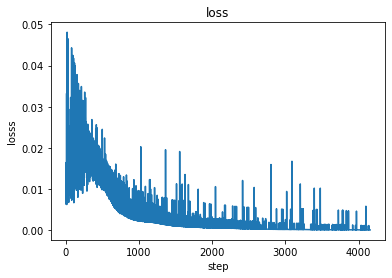

In [19]:
plt.figure()
plt.title('loss')
plt.plot(np.arange(len(losses)), losses)
plt.xlabel('step')
plt.ylabel('losss')
plt.show()

In [21]:
np.set_printoptions(precision=3, suppress=True)
pi

array([[0.   , 0.013, 0.987, 0.   ],
       [0.   , 0.276, 0.   , 0.724],
       [0.   , 0.   , 0.414, 0.586],
       [0.012, 0.977, 0.011, 0.   ],
       [0.   , 0.   , 0.988, 0.012],
       [1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.017, 0.983, 0.   , 0.   ]])